In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16_bn, VGG16_BN_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

from data_custom import CustomDataset, prepare_data
from utils.loops import train, evaluate
from utils.logger import Logger
from utils.checkpoint import save


In [2]:
weights = VGG16_BN_Weights.DEFAULT
model = vgg16_bn(weights=weights)
preprocess = weights.transforms()

In [3]:
preprocess_aug = transforms.Compose([
            preprocess,
            transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),])

In [4]:
def get_dataloaders(path, train_transform, test_transform, batch_size=32, augment=True, num_workers = 0):
    (xtrain, ytrain), (xval, yval), (xtest, ytest)  = prepare_data(path)
    

    train = CustomDataset(xtrain, ytrain, train_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers)
    valloader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=num_workers)
    testloader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

    return trainloader, valloader, testloader

In [5]:
train_loader, val_loader, test_loader = get_dataloaders('./Datasets/CustomFaceData', preprocess_aug, preprocess, num_workers=8)

In [6]:
for param in model.features.parameters():
    param.requires_grad = False

In [7]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [14]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=8, bias=True))

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
        net.parameters(),
        lr=0.001,
        momentum=0.9,
        nesterov=True,
        weight_decay=0.0001,
    )

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.75, patience=5, verbose=True
)

scaler = GradScaler()

In [16]:
logger = Logger()
path = os.path.join(os.getcwd(), "checkpoints", 'VGG_PT_CustomFaceData_SGD_RLRP_min')
if not os.path.exists(path):
    os.mkdir(path)
hparams = {
    'model_save_dir': path,
    'lr': 0.001
}

In [18]:
import warnings

warnings.filterwarnings("ignore")

print("Training", "on", device)


for epoch in range(100):

    acc_tr, loss_tr = train(net, train_loader, criterion, optimizer, scaler, Ncrop= False)
    logger.loss_train.append(loss_tr)
    logger.acc_train.append(acc_tr)

    acc_v, loss_v = evaluate(net, val_loader, criterion, Ncrop= False)
    logger.loss_val.append(loss_v)
    logger.acc_val.append(acc_v)

    scheduler.step(loss_v)

    print(f'Epoch {epoch + 1:02} Train Accuracy: {acc_tr:2.4}, Val Accuracy: {acc_v:2.6}')


Training on cuda:0


Epoch 00038: reducing learning rate of group 0 to 3.1641e-04.
Epoch 38 Train Accuracy: 66.71, Val Accuracy: 58.6863
Epoch 39 Train Accuracy: 67.27, Val Accuracy: 58.1181
Epoch 40 Train Accuracy: 66.87, Val Accuracy: 58.385
Epoch 41 Train Accuracy: 68.01, Val Accuracy: 58.6088
Epoch 42 Train Accuracy: 67.14, Val Accuracy: 58.6949
Epoch 43 Train Accuracy: 69.85, Val Accuracy: 58.5399
Epoch 00044: reducing learning rate of group 0 to 2.3730e-04.
Epoch 44 Train Accuracy: 68.06, Val Accuracy: 58.626
Epoch 45 Train Accuracy: 68.58, Val Accuracy: 58.7121
Epoch 46 Train Accuracy: 69.08, Val Accuracy: 58.9015
Epoch 47 Train Accuracy: 68.09, Val Accuracy: 58.7293
Epoch 48 Train Accuracy: 67.99, Val Accuracy: 58.6346
Epoch 49 Train Accuracy: 69.08, Val Accuracy: 58.8585
Epoch 00050: reducing learning rate of group 0 to 1.7798e-04.
Epoch 50 Train Accuracy: 69.11, Val Accuracy: 58.8154
Epoch 51 Train Accuracy: 69.41, Val Accuracy: 59.1426
Epoch 52 Train Accuracy: 69.7, Val Accuracy: 58.8154
Epoch 5

In [20]:
# Calculate performance on test set
acc_test, loss_test = evaluate(net, test_loader, criterion, Ncrop= False)
print(f'Test Accuracy: {acc_test:2.4}, Test Loss: {loss_test:2.6}')

Test Accuracy: 59.25, Test Loss: 0.0383241


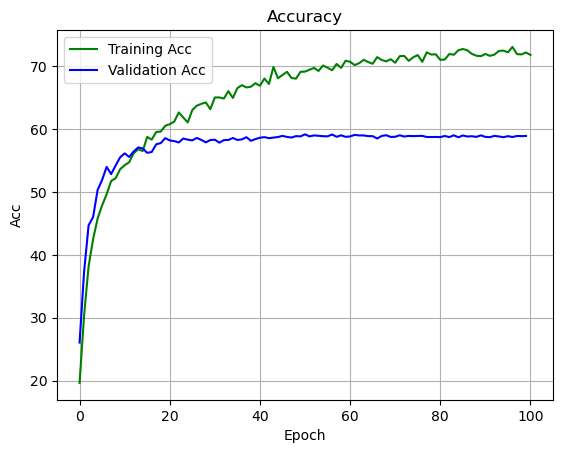

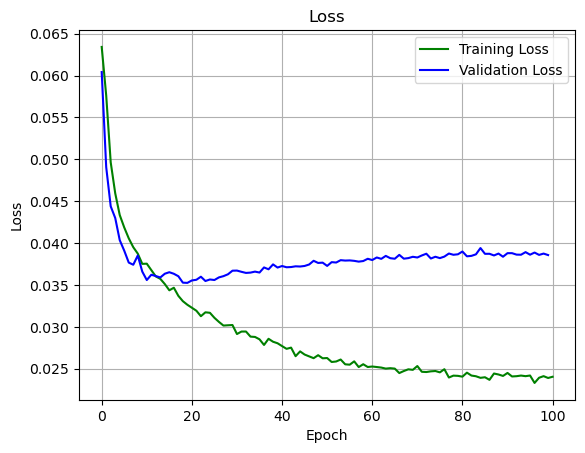

In [22]:
save(net, logger, hparams, epoch + 1)
logger.plot(hparams, save=True, show = True)